In [1]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string

%matplotlib inline

# 6 Overfitting, Regularization, and Information Criteria

**Ockham's Razor** making aesthetic/pragmatic preferenc for simpler model more explicit: prefer models w/ fewer assumptions. For same performance, choose simpler model. But what to do for different trade-offs in terms of simplicity vs accuracy? Content of this chapter.

Fundamental trade-off between **overfitting**, poor prediction by learning too much, and **underfitting**, poor prediction by learning too little. Need to navigate space in-between.

Methods to tackle: 

* **regularizing prior**, same as penalized likelihood in frequentist term, learn less from data
* **infromation criteria** to score models

**rethinking: stargazing.** common method of model selection: pick model with highest number of significant coefficients. but: p-values not designed to make under-/overfitting trade-off. helpful coeff. can be non-significant, significant coeff. can be unhelpful.

**rethinking: is aic bayesian?** not originally derived and often not seen as such, but can be interpreted as special limit of bayes. criterion like WAIC. example of common phenomenon in stats: same procedure can be dried and justified from multiple, sometimes philosophically incompatible perspectives.

## 6.1. the problem with parameters

Previous chapter: adding parameters can be helpful by revealing hidding effects. also, adding parameters can hurt if parameters are highly correlated. how about case of adding non-highly-correlated parameters? also not always safe.

two main problems:

* adding parameters nearly always makes model fit better, i.e. reduces train error. McElreath mentions $R^2$ or 'variance explained' metric. Increased for more predictor variables, even if they are random numbers. **understand 'variance explained', intuitive meaning unclear**
* more complex models often have better fit, but worse predictions on unseen data = overfit! but simple models tend to underfit. no simple answer, need to make trade-off.

### 6.1.1. more parameters always improve fit

Overfitting = learning too much from data

* regular features: useful, generalize well or inform about quesiton of interest
* irrregular features: misguiding, aspects of data that do not generalize

In [2]:
# Code 6.1

data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data).set_index('species')
d

brain  mass
species                 
afarensis      438  37.0
africanus      452  35.5
habilis        612  34.5
boisei         521  41.5
rudolfensis    752  55.5
ergaster       871  61.0
sapiens       1350  53.5

Q: assuming that brain size is generally correlated w/ body mass, which species have unexpectedly large brains for their body mass?

Common strategy: 'statistical control'. Fit lin. reg. between those two vars. Residuals of predicting brain vol from body mass = unexplained variance = come from other factors = unexpectedly high/low.

But: why lin. reg.? Why line? Might be some curve relating body mass to brain vol. Why not use residuals of that regression? That could be how things are in nature.

Fit increasingly complex models, observe fit.

In [3]:
# Code 6.2

m_6_1 = smf.ols('brain ~ mass', data=d).fit()

inspect $R^2$ of model. variance 'explained' by model = lin model predicts some variation of training data. remaining variation = variation of residuals

In [9]:
# Code 6.3

1 - m_6_1.resid.var() / d.brain.var()

0.490158047949084

In [12]:
# my own comparison: 
m_6_1.rsquared

0.490158047949084

In [13]:
m_6_1.summary()

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Fri, 22 Feb 2019   Prob (F-statistic):             0.0798
Time:                        11:41:32   Log-Likelihood:                -47.462
No. Observations:                   7   AIC:                             98.92
Df Residuals:                       5   BIC:                             98.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -227.6287    439.794     -0.518      0.627   -1358.154     902.897
mass          20.6889      9.436      2.192      0.080      -3.568      44.946
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Code 6.4

m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

In [15]:
# Code 6.5

m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

higher degree of polynomial = better fit, until 0 residuals for 6th degree, $R^2 = 1$

however: absurd model. curve follows all data points, but pays no price for absurd predictions like negative brain mass in areas without dat

reason: n params = n data points. use unique parameter to remember each datum.

**rethinking: model fitting as compression.** model fitting can be seen as data compression. parameters = summarize relationship among data in lossy way. use params to generate new data = decompress. if n params == n data points then no compression, just encoding in different way. consequence: learn nothing. need to use simpler model, but not too simpel. known as minimum description length.

### 6.1.2. too few parameters hurs, too

overfitting: low train error, high test error

underfitting: high train and test error. learned too little.

In [17]:
# Code 6.6

m_6_7 = smf.ols('brain ~ 1', data=d).fit()

estimate mean brain volume without considering brain mass = regression is horizontal line with wide confidence region. bad for seen and unseen data

underfit model = under-sensitive to data, changes too little based on seen data (inflexible)
overfit model = over-sensitive to data, changes too much based on seen data (volatile)

**overthinking: dropping rows.**

In [24]:
# Code 6.7

d_new = d.drop(d.index[0])

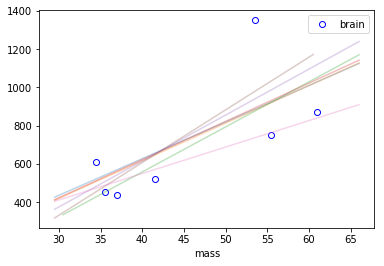

In [63]:
# Code 6.8
ax = d.plot.line(x='mass', y='brain', style=['ob'], fillstyle='none', mew=1)

for i in range(d.index.size):
    d_new = d.drop(d.index[i])

    m_0 = smf.ols('brain ~ mass', data=d_new).fit()

    x_pred = np.linspace(d_new.mass.min() -5, d_new.mass.max() + 5, 50)
    y_pred = m_0.params.Intercept + m_0.params.mass * x_pred

    ax.plot(x_pred, y_pred, alpha=.3);

**rethinking: bias and variance.** underfitting/overfitting also caused bias problems / variance problems. confusing nomenclature as these terms heavily overloaded in different contexts. also, increasing bias can improve predictions for unseen data.

## 6.2. information theory and model performance

Define what model needs to do well at: target. Proposed here: out-of-sample deviance

### 6.2.1. firing the weatherperson

Define target needs at least:

* cost-benefit. cost of wrong prediction, value of correct prediction
* performance in context. how good could a model be for this task?

#### 6.1.1.1. costs and benefits

different decision about better model for different cost/benefit analysis

#### 6.1.1.2. measuring accuracy

even if ignoring cost/benefit unclear which measure of accuracy to use. 

McElreath: joint probability is correct measure. reason: currectly counts up relative nr of ways each event could happen = likelihood in B's theorem. **revisit likelihood, model definition, model structure of earlier chapters**

"maximizing joint probability will identify right model" **what does right model mean?**

how to measure performance? should account for difficulty of task. ex: if adding more categories, task becomes harder.

**rethinking: what is a true model?** real world = deterministic. if all info was known, predictions would not be probabilities but just 1/0 for rain vs sunshine. but: we are ignorant of some information. 'right' = correct probabilities given our state of ignorance. "probability is in the model, not in the world". **but then, is each model a true model given its own assumptions of ignorance? unclear, discuss.**

### 6.2.2. information theory and uncertainty

information = reduction in uncertainty through learning an outcome

define: f(probability of rain) -> uncertainty

measure of uncertainty should be 

* continuous
* increasing for more events
* additive

exactly one f() satisfying all criteria: information entropy.

$$
H(p) = -E \log (p_i) = - \sum_{i=1}^n p_i \log (p_i)
$$

read: "uncertainty in a probability distribution is the average log-probability of an event"

McElreath does not explain derivation, but points out: all parts of definition are there for a reason, to satisfy requirements listed above. However, above all, information entropy being used b/c it's proven to be very productive and useful.

ex. on page illustrates: entropy of weather for Abu Dhabi much lower, as weather very uniform, thus low uncertainty. If adding 'snow' as weather condition: entropy/uncertainty increases.

code for calculating entropy for one example:

In [68]:
## Code 6.9

p = np.array([0.3, 0.7])
- np.sum((p * np.log(p)))

0.6108643020548935

**overthinking: more on entropy.** 
* "-1" in definition above customary but not necessary. leads to entropy increase from zero instead of decrease from one. 
* base of logarithm arbitrary, as long as same based used for all comparisons
* how to deal with 0-probabilty events? drop out. assume that $0 \log(0) = 0$. "not a trick but not obvious". remember: no sense to keep event that never happens in model.

**rethinking: the benefits of maximizing uncertainty** maximum entropy (maxent) = family of techniques for finding prob. distr. most consistent w/ current knowledge. given current knowledge, what distr. is least surprising? will be used to build GLMs later.

### 6.2.3. from entropy to accuracy

**discuss: entropy is way of quantifying uncertainty. but why is that necessary? already had probabilities around parameters to quantifiy uncertainty?**

How to use info entropy to measure model perf in distance from optimum? Divergence!

Divergence = "the additional uncertainty induced by using probabilities from one distribution to describe another distribution" = Kullback-Leibler divergence = K-L divergence

divergence(p,q) = KL(p,q) = "average difference in log proability between target p and model q"

difference of entropies: "entropy of target p and cross entropy of using q to predict p"

true probabilities = p
approximation = q

KL(p,q) = 0 iff p = q
KL(p,q) > 0 otherwise

grows the more q is different from p

**overthinking: cross entropy and divergence.** cross entropy: events arise according to p, but are expected according to q, inflating uncertainty. 

$$H(p,q) = - \sum_i p_i \log(q_i)$$ 

Divergence = additional uncertainty due to cross entropy, thus 

$$KL(p,q) = H(p,q) - H(p)$$

**rethinking: divergence depends upon direction.** my intuition: high entropy distribution = lots of ignorance = don't know what to expect, no event much more likely than others. use this to predict other distribution means we won't be super surprised by any outcome. 

flip side: low entropy distribution = lots of expectations = some events are much more likely than others. if we use low entropy distribution to predict other distribution and they don't match well: very surprised by outcome, high divergence. outcome has high information value?

### 6.2.4. from divergence to deviance
Know how to measure distance from true probability distr. $p$. But how to use in practice when $p$ is unknown? (wouldn't need to find model otherwise)

Solution: don't know distance from $p$, but can know whether $q$ or $r$ is relatively closer. Deviance as relative measure.

Summing log probabilities for each observed case gives approx of $E\log(q_i)$

Don't need to know $p$ in expectation term "because nature takes care of presenting the events to us". **what does that mean?**

absolute magnitude of deviance not meaningful, only difference between models is

deviance = 

$$
D(q) = -2 \sum_i \log(q_i)
$$

$i$ = case index, $q_i$ = likelihood of case $i$. divergence scales w/ sample size.

calc deviance by computing log-prop of observed data given MAP param estimates

In [72]:
# Code 6.10

m_6_1 = smf.ols('brain ~ mass', data=d).fit()

-2 * m_6_1.llf

94.92498968588757

uncertainty about params -> uncertainty about deviance. for fixed set of params deviance also fixed

**overthinking: computing deviance.**

In [83]:
# Code 6.11

d['mass_s'] = (d.mass - d.mass.mean()) / d.mass.std()

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    
    # why '*10'?
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    
    m_6_8 = pm.sample(2000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:10<00:00, 1309.07draws/s]


In [91]:
theta = pm.summary(m_6_8).loc[['a', 'b', 'sigma'], 'mean']
theta

a        713.748269
b          1.218698
sigma    369.997387
Name: mean, dtype: float64

In [98]:
dev = -2 * np.sum(stats.norm.logpdf(
    x = d['brain'], 
    loc = theta['a'] + theta['b'] * d['mass_s'], 
    scale = theta['sigma']
))
dev

100.18132665042522

### 6.2.5. from deviance to out-of-sample

Train deviance always improves for more complex model. Care about test (out-of-sample) deviance.

On average: test deviance will be worse than train deviance. However, can be reversed for an given train/test set. Any given training sample may be very misleading. Any given test sample might be highly non-representative. Don't test one sample too much. No guarantees in statistical inference.

"True" model might behave worse than other models due to those effects.

Conclusion: deviance on train data improves with more complex models. Deviance on test data might or might not, depending on actual data generation process and amount of train data available.

**Overthinking: simulated training and testing.** all R stuff, skip

In [99]:
# Code 6.12
# Code 6.13
# Code 6.14

# R stuff, does not seem useful to replicate

## 6.3 regularization

root cause of overfitting: model trusting training data too much. flat prior = all param values equally likely = model makes posterior that fits training data (through likelihood function) as much as possible

one solution: regularizing prior, slowing rate of learning from train data.

reg. prior requires tuning. too much reg. means model doesn't learn from useful features. too little means it learns from noise features.

no prior is optimal, "doing better is all we can hope for"

example: use prior of Normal(0, 1) for model coefficient, encodes belief that values greater than 2 or smaller than -2 are pretty unlikely. make more skeptical by giving smaller std dev, e.g. Normal(0, 0.5). 

how strong? depends on data and model.

the more data, the smaller effect of prior

how to pick strenght of regularization? if enough data: split into train/test and use that to tune, picking settings with lowest test deviance. essentially cross validation.

if not enough data available to split into train/test: information criteria (next chapter)

**rethinking: multilevel-models as adaptive regularization.** multilevel models learn strength of priors from data. can be seen as adaptive regularization.

**rethinking: rdige regression.** lin. models with Gaussian priors having 0 mean also called ridge regression. typically takes param to tune strenght of regularization. ridge regression does not compute posteriors, but includes reg. parameter into closed-form algebra solution for least squares approach. however, can also be seen as bayesian. another example of seeing one method from two perspectives.

## 6.4. information criteria

information criteria: provide estimate of out-of-sample deviance for model.

best-known criterion: akaike information criterion (aic):

$$
\text{AIC} = D_{train} + 2p
$$

where $p$ = number of free model params

All info criteria try to predict out-of-sample deviance for models but derived under different constraints and assumptions. For AIC these are:

* flat priors or dominated by llhood
* posterior is approx. multivar Normal
* nr of data points much greater than nr of params

'flat priors' harsh restriction, want to regularize. thus look for other criteria.

deviance information criterion (dic) and widely applicable information criterion (waic)

**rethinking: information criteria and consistency.** aic, dic, waic not consistent: do not necessarily assign best score to 'true' model. instead assign highest score to model with best expected out-of-sample predictive performance. issue? no, if goal is prediction. further 

furthermore, consistency defined for case dataset size going towards infinite, and in those info criteria give highest scores to most complex models. but in those cases v. complex behave like true model due to good fit.

### 6.4.1. dic

Aware of informative priors, but still assumes multivar Gaussian posterior. Thus results can be very wrong if that assumption not met.

Calculated from posterior of deviance, which is based on posterior uncertainty around parameters.

Calc deviance for each posterior sample. Let $\bar D$ be the average deviance and $\hat D$ the deviance at the posterior mean, then

$$
\text{DIC} = \bar D + (\bar D - \hat D) = \bar D + p_D
$$

$p_D$ encodes model complexity and penalizes DIC based on that. = expected distance between in-sample and out-of-sample deviance. for flat priors: dic = aic, as expected difference = nr of parameters. however, for informative priors, model more constrained, thus penalty fraction of nr of parameters. 

**discuss: why is $\bar D - \hat D$ = expected diff between in-sample and out-of-sample deviance?**

### 6.4.2. waic

essential characteristic: pointwise. considers uncertainty around each prediction individually. makes sense b/c some predictions are harder/more uncertain than others. aic/dic don't do this.

$$
Pr(y_i) = \text{avg}_{\text{posterior samples}}(P(y_i | \text{post. samp.})
$$

thus: average likelihood of $y_i$ over posterior

$$
lppd = \sum_{i=1}^N \log Pr(y_i)
$$

lppd = log pointwise predictive density = sum of log $Pr(y_i)$ across all data points = pointwise analog of deviance over posterior.

$$
V(y_i) = \text{variance of log-likelihood for sample i in train data}
$$

then

$$
p_{waic} = \sum_i^N V(y_i) = \text{effective nr of parameters}
$$

then

$$
waic = -2(\text{lppd} - p_{waic})
$$

again, estimating out of sample deviance.

issue: requires individual consideration of each datum. not meaningful for time series, where each datum depends on the one before. generally, assumes exchangeability.

generally: validity of any information criterion depends on predictive task.

**rethinking: what about bic?** bayesian info crit. (bic), or Schwarz criterion. not bayes/non-bayes choice to decide for/against this. can be motivaed from bayes/non-bayes perspective. bic related to lhood of data averaged over all priors = evidence in bayes formula -> comparing two models on evidence = bayes factor. not treated in this book

**overthinking: waic calculations.** see below

In [100]:
# Code 6.15
# Code 6.16
# Code 6.17
# Code 6.18
# Code 6.19
# Code 6.20

# not super relevant at the moment, skip


### 6.4.3. dic and waic as estimates of deviance

both accurate in given example. help to detect overfitting. complementery with regularization, which helps to reduce overfitting but does not detect/measure it.

**rethinking: diverse prediction frameworks.** 